In [1]:
#To begin, I'll import the packages that I'll be using.

import numpy as np
from numpy import nan
import pandas as pd

import scipy
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sb

import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\ecozzolino\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Next, I'll read in the data.
address = 'https://raw.githubusercontent.com/bethcozz/PSciHw/master/indeedpsci.csv'
indeed = pd.read_csv(address)
indeed.head(10)

,Unnamed: 0,advertiser_id,assigned,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created,age,assign_days,revenue
0,0,485,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-07-14,3855,138,NaN
1,1,598,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-08-02,3836,138,NaN
2,2,673,1,2017-02-01 00:00:00.000000,2017-04-28 15:36:30.000000,NaN,2006-08-17,3821,86,NaN
3,3,813,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-09-12,3795,138,NaN
4,4,1132,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-02,3744,138,NaN
5,5,1181,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-08,3738,138,NaN
6,6,1183,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-09,3737,138,NaN
7,7,1240,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-21,3725,138,NaN
8,8,1339,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-12-11,3705,138,NaN
9,9,1395,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-12-22,3694,138,NaN


In [3]:
#My understanding of the situation:
# Indeed has a system that routes leads to the sales team based on an
# estimate of the potential quality of each lead. Leads are assigned from highest to 
# lowest probability until each sales rep has a full sales book. 

#I don't have access to this probability. But, whether or not a lead
# is assigned - and the amount of time that a lead is assigned - each might reflect
# this underlying latent probability. Leads that are assigned should be assigned 
# because of their higher underlying probability of yielding revenue. Of the assigned
# leads, assign_days could reflect this probability too, with some leads
# assigned later in the process because they were a lower priority.

#If the assigned leads yield revenue and the unassigned leads do not,
# this is an indication that the prioritization has worked well. But, assigned
# leads that do not yield revenue and unassigned leads that do yield revenue each
# speak to a potential weakness in this prioritization scheme.

#Now, I'll take a look at the variables in this dataset.
indeed.describe()

#My assumptions about the data:
    #1. Date assignment starts = beginning of analysis period
        #seems to be almost uniformly 2/1/2017
    #2. Date assignment ends = end of analysis period
        #This varies more, with latest date looking like 6/19/2017
        #So together, it looks like our time period of analysis is 4 months in 2017.
    #3. Date created = earliest date that advertiser is in the system
        #These are typically years before the period of analysis,
        #though in some cases, they enter the system AFTER the analysis period
        #has begun.
    #4. Assign_days = the difference between date assingment starts
        #and date assignment ends, if a lead is assigned.
            #Alternatively, it could be the difference between the date assignment
            #starts and the first_revenue_date, if first_revenue_date occurrs during
            #the analysis period - effectively truncating the analysis for this 
            #lead, who we observe until they pay, or until the analysis period ends.
            #If a lead is unassigned, it's value on assign_days should be 0.
    #5. Age should be the difference between date_created and date_assignment_starts
        #measuring how long this lead has been around before the period of analysis.
    #6. First revenue date should measure the first time that a lead paid money 
        #to Indeed. In many cases, this first_revenue_date happens before our period
        #of observation begins. I would guess that these leads are higher priority, 
        #because they have paid out in the past. I would expect more of the leads with
        #a non-missing first_revenue_date to be assigned.
          #If first revenue date is missing, I'm assuming it means that this lead has never 
          #previously brought in revenue to Indeed. 
    #7. Revenue is the amount of money that a lead brought in during the period of analysis.
        #If revenue is missing, I'm assuming that this lead did not bring in any money
        #during the period of analysis.
  

,Unnamed: 0,advertiser_id,assigned,age,assign_days,revenue
count,77891.000000,7.789100e+04,77891.000000,77891.000000,77891.000000,3.340000e+03
mean,38945.000000,7.924271e+06,0.476037,309.958532,120.482546,4.865177e+07
std,22485.339246,3.918985e+06,0.499429,488.801166,39.527908,1.736891e+08
min,0.000000,4.850000e+02,0.000000,-27.000000,-2.000000,1.200000e+04
25%,19472.500000,4.317428e+06,0.000000,0.000000,136.000000,6.398444e+06
50%,38945.000000,1.078788e+07,0.000000,0.000000,137.000000,1.514775e+07
75%,58417.500000,1.080747e+07,1.000000,523.000000,138.000000,3.704959e+07
max,77890.000000,1.119963e+07,1.000000,3855.000000,138.000000,6.533791e+09


In [4]:
#Before answering the questions, I want to take care of the missing data.
indeed.isnull().any()
# The variables 'first_revenue_date' and 'revenue' both have missing values.
# I'm assuming that these values should be 0, because there has not been
# any revenue - either prior to the period of observation (first_revenue_date)
# or during the observation date (revenue).
# So, I'll create new variables that fill in the missing values with 0.

Unnamed: 0                False
advertiser_id             False
assigned                  False
date_assignment_starts    False
date_assignment_ends      False
first_revenue_date         True
date_created              False
age                       False
assign_days               False
revenue                    True
dtype: bool

In [5]:
#For revenue, , I create a new revenue column, called 'revenue2', which replaces NaN values with 0s.
indeed['revenue2']=indeed['revenue'].fillna(0)
indeed.describe()

,Unnamed: 0,advertiser_id,assigned,age,assign_days,revenue,revenue2
count,77891.000000,7.789100e+04,77891.000000,77891.000000,77891.000000,3.340000e+03,7.789100e+04
mean,38945.000000,7.924271e+06,0.476037,309.958532,120.482546,4.865177e+07,2.086209e+06
std,22485.339246,3.918985e+06,0.499429,488.801166,39.527908,1.736891e+08,3.728792e+07
min,0.000000,4.850000e+02,0.000000,-27.000000,-2.000000,1.200000e+04,0.000000e+00
25%,19472.500000,4.317428e+06,0.000000,0.000000,136.000000,6.398444e+06,0.000000e+00
50%,38945.000000,1.078788e+07,0.000000,0.000000,137.000000,1.514775e+07,0.000000e+00
75%,58417.500000,1.080747e+07,1.000000,523.000000,138.000000,3.704959e+07,0.000000e+00
max,77890.000000,1.119963e+07,1.000000,3855.000000,138.000000,6.533791e+09,6.533791e+09


In [6]:
#For first revenue date, I'm less interested in the date of first revenue, and more 
# interested in which leads are nonmissing on this variable.
indeed['anyfirstrev']=indeed['first_revenue_date'].fillna(0)
indeed['anyfirstrev'].head(20)
#So, I create an indicator for whether an advertising lead has ever given revenue.
# original 'first_revenue_date' variable, and filling in 0s for NaN values.

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10    2007-03-05
11             0
12    2007-06-18
13             0
14             0
15             0
16             0
17             0
18             0
19             0
Name: anyfirstrev, dtype: object

In [7]:
#Next, I complete the indicator variable by substituting the date
# of first revenue for a value of 1 (meaning, yes there has been revenue
# before from this lead).
indeed['anyfirstrev'] = np.where(indeed['anyfirstrev']!=0, 1, 0)
indeed.head(10)

,Unnamed: 0,advertiser_id,assigned,date_assignment_starts,date_assignment_ends,first_revenue_date,date_created,age,assign_days,revenue,revenue2,anyfirstrev
0,0,485,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-07-14,3855,138,NaN,0.0,0
1,1,598,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-08-02,3836,138,NaN,0.0,0
2,2,673,1,2017-02-01 00:00:00.000000,2017-04-28 15:36:30.000000,NaN,2006-08-17,3821,86,NaN,0.0,0
3,3,813,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-09-12,3795,138,NaN,0.0,0
4,4,1132,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-02,3744,138,NaN,0.0,0
5,5,1181,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-08,3738,138,NaN,0.0,0
6,6,1183,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-09,3737,138,NaN,0.0,0
7,7,1240,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-11-21,3725,138,NaN,0.0,0
8,8,1339,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-12-11,3705,138,NaN,0.0,0
9,9,1395,1,2017-02-01 00:00:00.000000,2017-06-19 12:12:37.888680,NaN,2006-12-22,3694,138,NaN,0.0,0


In [8]:
#Now that I've taken care of the missing data, I'll move onto the questions.

#QUESTION 1: How many leads are represented in this dataset?
#  To answer this question, I call the duplicated method on the feature
#  'advertiser_id' to see if there are any repeated values.
indeed.duplicated('advertiser_id')
ad_dups = indeed.advertiser_id[indeed.advertiser_id.duplicated()].values
ad_dups
# There are no duplicate entries for advertiser_id
#  so, there are 77,890 unique leads represented in this dataset.

array([], dtype=int64)

In [9]:
#QUESTION 1: How many leads are represented in this dataset?
#  To answer this question, I call the duplicated method on the feature
#  'advertiser_id' to see if there are any repeated values.
indeed.duplicated('advertiser_id')
ad_dups = indeed.advertiser_id[indeed.advertiser_id.duplicated()].values
ad_dups
# There are no duplicate entries for advertiser_id
#  so, there are 77,890 unique leads represented in this dataset.

array([], dtype=int64)

In [10]:
#QUESTION 1: Please describe both the assigned and unassigned populations.
#  To describe the unassigned and assigned populations, I call the groupby method
#  on the 'assigned' variable. The 'count' column tells me how many observations
#  are in each group.
indeed.groupby('assigned').describe()
# This shows that, of the ~77,000 leads, 40,812 are unassigned and 37,079 are assigned.

Unnamed: 0                                                       \
              count          mean           std   min       25%      50%   
assigned                                                                   
0           40812.0  55228.617318  13686.097612  33.0  44296.75  55528.5   
1           37079.0  21021.998031  15582.937167   0.0   9409.50  18882.0   

                            advertiser_id                    ...       \
               75%      max         count          mean      ...        
assigned                                                     ...        
0         66938.25  77824.0       40812.0  1.068360e+07      ...        
1         28417.50  77890.0       37079.0  4.887142e+06      ...        

             revenue               revenue2                                   \
                 75%           max    count          mean           std  min   
assigned                                                                       
0         24672039.5  6.533791e+09  40812.0  1.039001e+06  3.322616e+07  0.0   
1         58548372.0  2.500000e+09  37079.0  3.238846e+06  4.126909e+07  0.0   

                                       
          25%  50%  75%           max  
assigned                               
0         0.0  0.0  0.0  6.533791e+09  
1         0.0  0.0  0.0  2.500000e+09  

[2 rows x 56 columns]

In [11]:
indeed.groupby('assigned').mean()
# To further describe these two groups, I look at the means of each group.
# Compared to unassigned leads, the age of assigned leads is bigger, 
# the number of assign days is smaller, and revenue is higher.

#QUESTION 1: What is the average revenue of each group?
# Of assigned leads that have any revenue, the average revenue is $76,736,860.
#  Of all of the assigned leads (including those that do not yield revenue),
#  the average revenue is $3,238,846 (the value from the 'revenue2' column).

# Of unassigned leads that have any revenue, the average revenue is $23,889,420.
#  Of all of the unassigned leads (including those that do not yield revenue),
#  the average revenue is $1,039,001 (the value from the 'revenue2' column).

,Unnamed: 0,advertiser_id,age,assign_days,revenue,revenue2,anyfirstrev
assigned,,,,,,,
0,55228.617318,1.068360e+07,11.907919,124.014971,2.388942e+07,1.039001e+06,0.069832
1,21021.998031,4.887142e+06,638.015966,116.594487,7.673686e+07,3.238846e+06,0.150570


In [12]:
# It looks like these values are quite different, but is this difference 
# statistically significant? To answer this question, I do a Chi2 test.
table = pd.crosstab(indeed.assigned, indeed.revenue)
chi2, p, dof, expected = chi2_contingency(table.values)
print('Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p))
# The revenue of assigned and unassigned groups is significantly different.

Chi-square Statistic 3131.347 p_value 0.017


In [13]:
#QUESTION 2: What are the most important metrics to consider
# in this data set? Why?

# The key outcome variable in this dataset is revenue, and the
#  key explanatory variable is whether or not a lead has been assigned.
# From the prompt, these variables - and account age - seem to be
#   of greatest interest. However, I can't comment on which metrics
#   have the greatest explanatory power until after I've run my model.
#   I will return to this question below, after Question 4. 

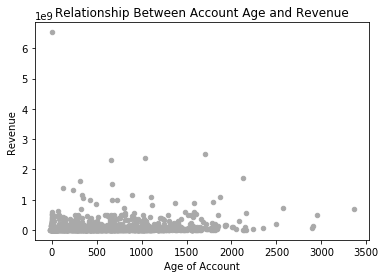

In [14]:
#QUESTION 3: Analyze any existing relationship between account age 
# and revenue, through visualization and other means.

# To begin, I plot age (x-axis) against revenue (y-axis)
%matplotlib inline 
indeed.plot(kind='scatter', x='age', y='revenue', c=['darkgray'], s=20)
plt.xlabel('Age of Account')
plt.ylabel('Revenue') 
plt.title('Relationship Between Account Age and Revenue')
plt.show()

#From this graph, we  can see that there's no easily discernable
# shape to the relationship between these two variables. Most of the
# revenue values cluster close to the bottom of the y-axis, regardless
# of the age of the account.

In [15]:
#Another way to analyze this relationship would be to look at the 
# correlation between these two variables. I do this using the 
# Pearson R Correlation. 
pearsonr_coefficient, p_value = pearsonr(indeed.age, indeed.revenue2)
print('PearsonR Correlation Coefficient %0.3f' % (pearsonr_coefficient))
#I find that there is a weak positive relationship b/w age and revenue (0.02)

PearsonR Correlation Coefficient 0.027


In [16]:
#QUESTION 4: What is the incremental value from assigning a lead to the sales team?

#To answer this question, I'll run a linear regression, using the numerical variables
# in the dataset to predict revenue. 

#First, I create a trim dataset that includes only the numerical variables
indeed_trim = indeed[['assigned', 'age', 'assign_days', 'revenue2', 'anyfirstrev']]
indeed_trim.head(10)

,assigned,age,assign_days,revenue2,anyfirstrev
0,1,3855,138,0.0,0
1,1,3836,138,0.0,0
2,1,3821,86,0.0,0
3,1,3795,138,0.0,0
4,1,3744,138,0.0,0
5,1,3738,138,0.0,0
6,1,3737,138,0.0,0
7,1,3725,138,0.0,0
8,1,3705,138,0.0,0
9,1,3694,138,0.0,0


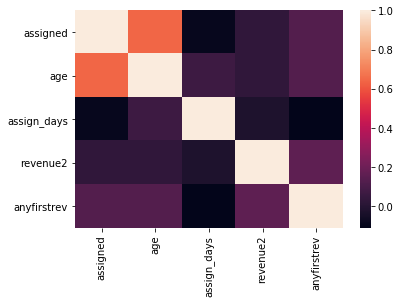

In [17]:
#I'll explore this trim dataset by graphing a heatmap of correlations
# between all of the variables. 
X = indeed_trim
corr = X.corr()
corr
sb.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()
#It looks like the strongest correlation here between any two variables
# is between 'assigned' and 'age'.

In [18]:
#Next, I prepare my X and y variables for modeling.
y = indeed_trim.revenue2
X = indeed_trim.drop(['revenue2'], axis=1)
#Revenue2 is the outcome variable, and the rest of the variables are X's.

In [19]:
#Finally, I fit a linear regression to these data.
results = sm.OLS(y, X).fit()
results.summary()

# Whether or not a lead has been assigned is only marginally positively associated with revenue,
# meaning that assignment marginally increases revenue. But, the coefficient ($578,400)
# is quite big. Therefore, the incremental value of assigning a lead
# to a sales team is about $578,000 (but the relationship is only marginally significance).

#Other findings from this model:
# 1. Age does not significantly predict revenue.
# 2. The number of days assigned is negatively associated with revenue, meaning that 
#    the longer that a lead is assigned, the lower the revenue 
#    (Each additional day assigned is associated with a decline in revenue of $2,715)
# 3. Any first revenue (my dummy variable indicating whether the there was a non-
#    missing value on first_revenue) positively predicts revenue. This means that leads
#    who have previously given revenue have outcome revenues $19,100,000 higher than those
#    who have not previously given revenue.

# Returning to Question 2 (What metrics are most important to consider and why?), it looks
# as though my indicator variable of anyfirstrev is the most predictive of revenue. The
# number of assigned days is also significantly associated with revenue. Age was not a significant
# factor, and whether or not a lead was assigned was only marginally significant.

# One final thing to note is that the R2 of this model is quite low 
# (only 0.03% of variation is explained by this model).

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               revenue2   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     579.8
Date:                Fri, 05 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:43:51   Log-Likelihood:            -1.4675e+06
No. Observations:               77891   AIC:                         2.935e+06
Df Residuals:                   77887   BIC:                         2.935e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
assigned     5.784e+05   3.27e+05      1.770      0.077   -6.22e+04    1.22e+06
age           158.2291    352.812      0.448      0.654    -533.281     849.739
assign_days -2715.4611   1357.946     -2.000      0.046   -5377.027     -53.895
anyfirstrev   1.91e+07   4.25e+05     44.893      0.000    1.83e+07    1.99e+07
==============================================================================
Omnibus:                   300583.604   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     597686978124.814
Skew:                          91.177   Prob(JB):                         0.00
Kurtosis:                   13572.369   Cond. No.                     1.90e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.9e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
#BONUS QUESTION.Because the R2 of my linear regression model was so low,
# I thought a little bit about other models that I could run with these data.
# Because so many of the leads had a revenue value of 0, I was curious what 
# separated the leads with ANY revenue from those with none. 

#To answer this question, I first had to create a binary variable for whether
# or not there was any revenue during the period of observation.
indeed['anyrev'] = np.where(indeed['revenue2']!=0, 1, 0)

In [21]:
#Next, I recreate the indeed_trim dataset, substituting 'anyrev' for 'revenue2'
indeed_trim = indeed[['assigned', 'age', 'assign_days', 'anyrev', 'anyfirstrev']]

#I also recreated the X and y to prepare for my logistic regression.
y = indeed_trim.anyrev
X = indeed_trim.drop(['anyrev'], axis=1)

In [22]:
logit = sm.Logit(y, X)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.109740
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 anyrev   No. Observations:                77891
Model:                          Logit   Df Residuals:                    77887
Method:                           MLE   Df Model:                            3
Date:                Fri, 05 Jan 2018   Pseudo R-squ.:                  0.3800
Time:                        16:43:51   Log-Likelihood:                -8547.8
converged:                       True   LL-Null:                       -13786.
                                        LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
assigned       -1.9489      0.049    -39.465      0.000      -2.046      -1.852
age            -0.0007    

In [23]:
print(np.exp(result.params))
# I exponentiate these coefficients for easier interpretation.

# The results of the logistic regression on ANY revenue look somewhat different
#  from the results of the linear regression I did in Question 4. 
#   1. First of all, being assigned to a salesperson actually REDUCES the odds of 
#    ANY revenue from that lead (by 86%).  
#   2. Having any previous revenue from that lead ('anyfirstrev') increases the odds of 
#    any revenue during the period of observation by a very large factor (~120x)
#   3. Finally, age and assign_days both reduce the odds of any revenue, 
#    but by small magnitudes (1% and 3% respectively)

# Also, the R2 of this logistic regression is much higher than that of the linear
# regression from Quetion 4. Here, the R2 is .38, meaning that 38% of the variance 
# in who does/does not pay out revenue is explained by this model. This model explains
# 35% more variance than the linear regression model. 

#To return to my undestanding of the situation above, it seems to me that the 
# prioritization scheme dictating which leads are and are not assigned is not 
# working terribly well. The only other interpretation would be that having a 
# sales rep working on a lead actually DETERS leads from paying - which seems unlikely!

assigned         0.142425
age              0.999340
assign_days      0.967458
anyfirstrev    121.280155
dtype: float64
